<a href="https://colab.research.google.com/github/PochkaChaiki/gasReserves/blob/main/GasReservesCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [559]:
# !pip install ipdb

In [560]:
import pdb
%pdb on

Automatic pdb calling has been turned ON


## Imports

In [561]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy.optimize as so
from matplotlib import pyplot as plt
import seaborn as sns

In [562]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

Constants

In [563]:
zero_c_to_k = 273
norm_temp_c = 20
pres_std_cond = 0.101325 * 1e6

## Initial data

In [564]:
amount_of_vars = 3000

In [565]:
df_init_data = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef', 'init_reservoir_pressure',
                                     'relative_density', 'reservoir_temp', 'permeability'],
                            index=['value', 'min', 'max'])

df_init_data['area']                       = {"value":38_556 * 1e3, "min":36_628.20 * 1e3 , "max":40_483.80 * 1e3}
df_init_data['effective_thickness']        = {"value":11.10,   "min":10.50,     "max":12.15}
df_init_data['porosity_coef']              = {"value":0.091,    "min":0.0067,      "max":0.1278}
df_init_data['gas_saturation_coef']        = {"value":0.7,     "min":0.65,      "max":0.75}
df_init_data['init_reservoir_pressure']    = {"value":32.30 * 1e6,   "min":29.07 * 1e6,     "max":35.53 * 1e6}
df_init_data['relative_density']           = {"value":0.6348,    "min":0.6267,      "max":0.6429}
df_init_data['reservoir_temp']             = {"value":320.49,  "min":288.44,    "max":352.54}
df_init_data['permeability']               = {"value":0.75,    "min":0.002,         "max":19.14}

In [566]:
df_init_data

,area,effective_thickness,porosity_coef,gas_saturation_coef,init_reservoir_pressure,relative_density,reservoir_temp,permeability
value,38556000.0,11.10,0.0910,0.70,32300000.0,0.6348,320.49,0.750
min,36628200.0,10.50,0.0067,0.65,29070000.0,0.6267,288.44,0.002
max,40483800.0,12.15,0.1278,0.75,35530000.0,0.6429,352.54,19.140


## Results

In [567]:
df_result_data = pd.DataFrame(columns=['area_volume', 'pore_volume', 'temp_correction', 'fin_reservoir_pressure',
                                       'critical_pressure', 'critical_temp', 'init_overcompress_coef',
                                       'fin_overcompress_coef', 'geo_gas_reserves', 'dry_gas_init_reserves'],
                              index=['value', 'min', 'max'])

df_result_data['area_volume']            = df_init_data['area'] * df_init_data['effective_thickness']
df_result_data['pore_volume']            = df_result_data['area_volume'] * df_init_data['porosity_coef']
df_result_data['temp_correction']        = (zero_c_to_k * 2 + norm_temp_c) / (zero_c_to_k + df_init_data['reservoir_temp'] )
df_result_data['fin_reservoir_pressure'] = np.exp(1293 * 1e-9 * 2700 * df_init_data['relative_density']) # What are this magical numbers?
df_result_data['critical_pressure']      = (4.892 - 0.4048 * df_init_data['relative_density']) * 1e6 # Same question
df_result_data['critical_temp']          = 94.717 + 170.8 * df_init_data['relative_density'] # Same question
df_result_data['init_overcompress_coef'] = (0.4 * np.log10(df_init_data['reservoir_temp'] / df_result_data['critical_temp']) + 0.73)**(df_init_data['init_reservoir_pressure'] / df_result_data['critical_pressure']) + 0.1 * df_init_data['init_reservoir_pressure'] / df_result_data['critical_pressure'] # Same question
df_result_data['fin_overcompress_coef']  = (0.4 * np.log10(df_init_data['reservoir_temp'] / df_result_data['critical_temp']) + 0.73)**(df_result_data['fin_reservoir_pressure'] / df_result_data['critical_pressure']) + 0.1 * df_result_data['fin_reservoir_pressure'] / df_result_data['critical_pressure'] # Same question
df_result_data['geo_gas_reserves']       = df_init_data['area'] * df_init_data['effective_thickness'] * df_init_data['porosity_coef'] * df_init_data['gas_saturation_coef'] * df_init_data['init_reservoir_pressure'] / df_result_data['init_overcompress_coef'] / pres_std_cond * df_result_data['temp_correction']

df_result_data['dry_gas_init_reserves']  = df_result_data['geo_gas_reserves'] * (100 - 0.012 - 0.003 - 0.012) / 100 # You're kidding me! Same question
df_result_data

,area_volume,pore_volume,temp_correction,fin_reservoir_pressure,critical_pressure,critical_temp,init_overcompress_coef,fin_overcompress_coef,geo_gas_reserves,dry_gas_init_reserves
value,427971600.0,3.894542e+07,0.953681,1.002219,4635032.96,203.14084,0.925583,1.0,8.954221e+09,8.951803e+09
min,384596100.0,2.576794e+06,1.008122,1.002190,4638311.84,201.75736,0.858788,1.0,5.640901e+08,5.639378e+08
max,491878170.0,6.286203e+07,0.904818,1.002247,4631754.08,204.52432,0.994840,1.0,1.503614e+10,1.503208e+10


In [568]:
df_stat_params = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef', 'permeability'],
                            index=['distribution', 'params'])
df_stat_params['area'] = {'distribution': 'norm', 'params': {'mean': 38556 * 1e3, 'sigma': 3650 * 1e3}}
df_stat_params['effective_thickness'] = {'distribution': 'norm', 'params': {'mean': 11.10, 'sigma': 0.867}}
df_stat_params['porosity_coef'] = {'distribution': 'norm', 'params': {'mean': 0.09, 'sigma': 0.013}}
df_stat_params['gas_saturation_coef'] = {'distribution': 'norm', 'params': {'mean': 0.7, 'sigma': 0.01}}
df_stat_params['permeability'] = {'distribution': 'norm', 'params': {'mean': 9.569, 'sigma': 6.766}}

#First

## Statistic

In [569]:
df_stat_data = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef'])

for var in df_stat_data.columns:
    loc, scale = tuple(df_stat_params[var]['params'].values())
    # lb, rb = (df_init_data[var]['min'] - loc) / scale, (df_init_data[var]['max'] - loc) / scale
    # df_stat_data[var] = st.truncnorm.rvs(lb, rb, loc=loc, scale=scale, size=amount_of_vars)
    df_stat_data[var] = st.norm.rvs(loc=loc, scale=scale, size=amount_of_vars)

In [570]:
# area                = st.truncnorm.rvs(*(df_init_data['area']['min'], df_init_data['area']['max'], *tuple(df_stat_params['area']['params'].values()), amount_of_vars))

In [571]:
reserves = df_stat_data.prod(axis=1) * df_init_data['init_reservoir_pressure']['value'] * df_result_data['temp_correction']['value'] / df_result_data['init_overcompress_coef']['value'] / pres_std_cond

In [572]:
fig = make_subplots(rows=1, cols=5)
for var, i in zip(df_stat_data.columns, range(1,6)):
    fig.add_trace(
        go.Histogram(x=df_stat_data[var], nbinsx=14), row=1, col=i)

fig.add_trace(go.Histogram(x=reserves, nbinsx=14), row=1, col=5)
fig

### Params sensitivity

In [573]:
df_sens = pd.DataFrame(dict(min=df_stat_data.min(), mean=df_stat_data.mean(), max=df_stat_data.max()))
df_sens

,min,mean,max
area,2.498977e+07,3.847658e+07,5.338558e+07
effective_thickness,8.037881e+00,1.110129e+01,1.394722e+01
porosity_coef,4.170228e-02,8.985498e-02,1.382976e-01
gas_saturation_coef,6.685382e-01,7.001292e-01,7.370732e-01


In [574]:
const_multiplier = df_init_data['init_reservoir_pressure']['value'] * df_result_data['temp_correction']['value'] / df_result_data['init_overcompress_coef']['value'] / pres_std_cond

In [575]:
df_reserves_affection = pd.DataFrame(columns=['min', 'max'], index=df_sens.index)
for var in df_sens.index:
    df_reserves_affection['min'][var] = reserves.mean() - df_sens['min'][var] * df_sens.loc[df_sens.index != var]['mean'].prod() * const_multiplier
    df_reserves_affection['max'][var] = df_sens['max'][var] * df_sens.loc[df_sens.index != var]['mean'].prod() * const_multiplier - reserves.mean()
df_reserves_affection

,min,max
area,3088774840.219375,3424832120.136469
effective_thickness,2430628457.252127,2267547672.504986
porosity_coef,4724881164.952764,4763184720.678835
gas_saturation_coef,393329307.874772,470638612.632595


In [576]:
df_affection = pd.DataFrame(dict(
    kmin=df_reserves_affection['min']/df_reserves_affection['min'].sum(),
    kmax=abs(df_reserves_affection['max'])/df_reserves_affection['max'].sum()
))
df_affection

,kmin,kmax
area,0.290364,0.313451
effective_thickness,0.228494,0.207533
porosity_coef,0.444167,0.435941
gas_saturation_coef,0.036975,0.043074


In [577]:
fig2 = make_subplots(rows=1,cols=2)
fig2.add_trace(
    go.Bar(
        x=df_affection['kmin'],
        y=df_affection.index,
        orientation='h',
        name='Влияние в меньшую сторону',
        ),
    row=1,
    col=1
)
fig2.add_trace(
    go.Bar(
        x=df_affection['kmax'],
        y=df_affection.index,
        orientation='h',
        name='Влияние в большую сторону',
        ),
    row=1,
    col=2
)

fig2.update_layout(
    xaxis=dict(
        domain=[0.0, 0.5],
        autorange="reversed"
    ),
    xaxis2=dict(domain=[0.5, 1]),
    yaxis=dict(ticklabelstandoff=15),
    yaxis2=dict(visible=False),
    legend=dict(
        orientation='h',
        xanchor='center',
        x=0.5
    )
)


annotations=[]

# Adding labels
for ykmin, ykmax, xd in zip(df_affection['kmin'], df_affection['kmax'], df_affection.index):
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=ykmin+0.03,
                            text=str(np.round(ykmin*100, 1)) + '%',
                            showarrow=False))
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ykmax+0.03,
                            text=str(np.round(ykmax*100, 1)) + '%',
                            showarrow=False))

fig2.update_layout(annotations=annotations)
fig2

### P10, P50, P90

In [578]:
p10 = st.norm.ppf(0.9, loc=reserves.mean(), scale=reserves.std())
p50 = st.norm.ppf(0.5, loc=reserves.mean(), scale=reserves.std())
p90 = st.norm.ppf(0.1, loc=reserves.mean(), scale=reserves.std())
p90, p50, p10

(6700554932.361897, 8821083292.077421, 10941611651.792946)

In [579]:
df_prob_estimates = pd.DataFrame(dict(
    p90=st.norm.ppf(0.1, loc=df_stat_data.mean(), scale=df_stat_data.std()),
    p50=st.norm.ppf(0.5, loc=df_stat_data.mean(), scale=df_stat_data.std()),
    p10=st.norm.ppf(0.9, loc=df_stat_data.mean(), scale=df_stat_data.std()),
), index=df_stat_data.columns)
df_prob_estimates.loc["reserves"] = [p90, p50, p10]
df_prob_estimates

,p90,p50,p10
area,3.383402e+07,3.847658e+07,4.311914e+07
effective_thickness,9.962810e+00,1.110129e+01,1.223978e+01
porosity_coef,7.327524e-02,8.985498e-02,1.064347e-01
gas_saturation_coef,6.873614e-01,7.001292e-01,7.128969e-01
reserves,6.700555e+09,8.821083e+09,1.094161e+10


In [580]:
# fig3 = go.Figure()
fig3 = px.ecdf(reserves)
fig3.add_trace(go.Scatter(x=[p90, p50, p10], y=[0.1, 0.5, 0.9], mode='markers', marker_size=20))
fig3

# Second

## Development indicators

In [581]:
permeability = abs(st.norm.rvs(loc=df_stat_params['permeability']['params']['mean'], scale=df_stat_params['permeability']['params']['sigma'], size=amount_of_vars))
permeability.mean(), permeability.std()

(9.890538385385636, 5.9936590833239975)

In [582]:
permeability_p10 = st.norm.ppf(0.9, loc=permeability.mean(), scale=permeability.std())
permeability_p50 = st.norm.ppf(0.5, loc=permeability.mean(), scale=permeability.std())
permeability_p90 = st.norm.ppf(0.1, loc=permeability.mean(), scale=permeability.std())
permeability_p10, permeability_p50, permeability_p90

(17.571721566960118, 9.890538385385636, 2.2093552038111524)

##Hiding stuff

In [583]:
# init_pressure = df_init_data['init_reservoir_pressure']['value'] / 10**6
# reservoir_temp = df_init_data['reservoir_temp']['value']
# relative_density = df_init_data['relative_density']['value']
# init_overcompress_coef = df_result_data['init_overcompress_coef']['value'] # 0.94
# max_depression = 2 * 1e6 / 10**6
# required_whole_gas_production = 12 * 1e7 / 10**6
# reserve_ratio = 1.05
# operations_ratio = 0.98
# porosity_coef = df_init_data['porosity_coef']['value']
# gas_saturation_coef = 0.72                             # alpha
# avg_well_temp = (reservoir_temp + 293) / 2
# pipe_diameter = 0.114
# well_height = 2700
# pipe_roughness = 0.0001
# init_num_wells = 1
# trail_length = 2300
# trail_diameter = 0.168
# trail_roughness = 0.0001
# avg_trail_temp = 323.15
# main_gas_pipeline_pressure = 4 * 1e6 / 10**6
# input_cs_temp = 310
# coef_K = 3326400
# efficiency_cs = 0.87
# adiabatic_index = 1.3
# density_athmospheric = relative_density * 28.96 / 22.4
# viscosity = 0.012

# lambda_trail = 0.067 * (2 * trail_roughness / trail_diameter)**0.2

In [584]:
# lambda_fontain = (2 * np.log10(7.41 * pipe_diameter/ 2 / pipe_roughness))**(-2)

In [585]:
# effective_thickness = df_prob_estimates['p50']['effective_thickness']
# geo_gas_reserves = df_prob_estimates['p10']['reserves'] / 10**6
# annual_production = geo_gas_reserves * 0.045
# permeability_k = permeability_p50
# macro_roughness_l = 0.425 * 1e-9 * permeability_k ** 1.45 /100
# filtr_resistance_A = viscosity *  init_overcompress_coef * 0.1013 * reservoir_temp / (np.pi * permeability_k * effective_thickness * 293.15) * np.log(500/0.1) * 11.347 * 1e3
# filtr_resistance_B = density_athmospheric * 0.1013 *  init_overcompress_coef * reservoir_temp / macro_roughness_l / (2 * np.pi**2 *  effective_thickness**2 * 293.15) * (1/0.1 - 1/500) * 10**(-6) / 86400**2 * 1e3

In [586]:
# annual_production, geo_gas_reserves

In [587]:
# filtr_resistance_A, filtr_resistance_B, macro_roughness_l

Initial values of varying parameters

In [588]:
# year = [0]
# current_annual_production = 0
# sum_current_annual_production = 0
# current_pressure = init_pressure
# overcompress_coef = init_overcompress_coef

In [589]:
# kig = 0
# current_daily_production = 0
# downhole_pressure = current_pressure - max_depression

# s = 0
# overcomp_coef_avg = 0
# theta = 0

# n_wells = 0

# machines_num = 1
# time_to_build = 6


In [590]:
# list_annual_production = []
# list_current_pressure = []
# list_overcompress_coef = []
# list_daily_production = []
# list_n_wells = []
# list_kig = []
# list_wellhead_pressure = []

# list_ukpg_pressure = []
# list_cs_power = []

Depends on dev indics mode:

In [591]:
# def count_daily_production(x):
#     return (-filtr_resistance_A + np.sqrt(filtr_resistance_A**2 + 4 * filtr_resistance_B * max_depression * (2*x - max_depression))) / 2 / filtr_resistance_B

In [592]:
# def count_overcomp_coef(x, temp):
#     return (0.4 * np.log10(temp / df_result_data['critical_temp'].value) + 0.73)**(x / df_result_data['critical_pressure'].value * 1e6) + 0.1 * x / df_result_data['critical_pressure'].value * 1e6

In [593]:
# while (kig < 0.5):

#     if current_daily_production * n_wells * operations_ratio * 365 / 1000 <= annual_production:
#         n_wells += np.trunc(12 / (machines_num * time_to_build))


#     def func(x):
#         return [init_pressure / init_overcompress_coef * (1 - sum_current_annual_production / geo_gas_reserves) * x[1] - x[0],
#                 count_overcomp_coef(x[0], reservoir_temp) - x[1],
#                 sum_current_annual_production + 365 * n_wells * operations_ratio * count_daily_production(x[0]) / 1000 - x[2]]

#     current_pressure, overcompress_coef, _ = so.fsolve(func, [current_pressure, overcompress_coef, sum_current_annual_production], xtol=1e-3)
#     # current_pressure, overcompress_coef = so.broyden1(func, [current_pressure, overcompress_coef], f_tol=1e-1, verbose=True)
#     current_daily_production = count_daily_production(current_pressure)

#     if (current_pressure - max_depression > 0):
#         downhole_pressure = current_pressure - max_depression
#     else:
#         downhole_pressure = 0;

#     s = 0.03415 * relative_density * well_height / overcompress_coef / avg_well_temp
#     # using Pt instead of Pcp --->
#     overcomp_coef_avg = count_overcomp_coef(current_pressure, avg_well_temp)
#     theta = 0.0132 * 10**(-10) * lambda_fontain * overcomp_coef_avg**2 * avg_well_temp**2 * (np.exp(2 * s) - 1) / pipe_diameter**5

#     if downhole_pressure > 0:
#         wellhead_pressure = np.sqrt((downhole_pressure**2 - theta * current_daily_production**2) / np.exp(2 * s))
#     else:
#         wellhead_pressure = 0


#     if 365 * current_daily_production * n_wells * operations_ratio / 1000 > annual_production:
#         current_annual_production = annual_production
#     else:
#         current_annual_production = 365 * current_daily_production * n_wells * operations_ratio / 1000

#     ukpg_pressure = np.sqrt(wellhead_pressure**2 - lambda_trail * relative_density * \
#     count_overcomp_coef(2/3 * (downhole_pressure + wellhead_pressure**2 / (downhole_pressure + wellhead_pressure)), avg_well_temp)\
#     * avg_trail_temp * trail_length * (current_daily_production * n_wells)**2 / trail_diameter**5 / coef_K**2 )

#     power = 0
#     if ukpg_pressure < main_gas_pipeline_pressure:
#         power = 0.004 * current_daily_production * n_wells * input_cs_temp * \
#           count_overcomp_coef(ukpg_pressure, input_cs_temp) / \
#           efficiency_cs * adiabatic_index / (adiabatic_index - 1) * \
#           ((main_gas_pipeline_pressure/ukpg_pressure)**((adiabatic_index - 1) / adiabatic_index) - 1)

#     sum_current_annual_production += current_annual_production
#     kig = sum_current_annual_production / geo_gas_reserves

#     list_kig.append(kig)
#     list_annual_production.append(current_annual_production)
#     list_current_pressure.append(current_pressure)
#     list_n_wells.append(n_wells)
#     list_wellhead_pressure.append(wellhead_pressure)
#     list_ukpg_pressure.append(ukpg_pressure)
#     list_cs_power.append(power)

#     year.append(year[-1]+1)

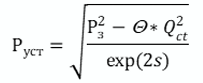

In [594]:
# firstLoopResults = pd.DataFrame(dict(kig = list_kig, annual_production = list_annual_production, current_pressure = list_current_pressure, wellhead_pressure = list_wellhead_pressure, n_wells = list_n_wells))

In [595]:
# firstLoopResults

Not finished ---V!!!

In [596]:
# while current_pressure > 0.05 * init_pressure and wellhead_pressure>0.1:


#     def func(x):
#         return [init_pressure / init_overcompress_coef * (1 - x[2] / geo_gas_reserves) * x[1] - x[0],
#                 count_overcomp_coef(x[0], reservoir_temp) - x[1],
#                 sum_current_annual_production + 365 * n_wells * operations_ratio * (current_daily_production + count_daily_production(x[0])) / (2 * 10**6 * reserve_ratio) *1e3 - x[2]]

#     # current_pressure, overcompress_coef = so.fsolve(func, [current_pressure, overcompress_coef], xtol=1e-1)
#     current_pressure, overcompress_coef, _ = so.newton_krylov(func, [current_pressure, overcompress_coef, sum_current_annual_production], f_tol=1e-1, verbose=True)
#     new_current_daily_production = count_daily_production(current_pressure)

#     if (current_pressure - max_depression > 0):
#         downhole_pressure = current_pressure - max_depression
#     else:
#         downhole_pressure = 0

#     s = 0.03415 * relative_density * well_height / overcompress_coef / avg_well_temp
#     overcomp_coef_avg = count_overcomp_coef(current_pressure, avg_well_temp)
#     theta = 0.0132 * 10**(-10) * lambda_fontain * overcomp_coef_avg**2 * avg_well_temp**2 * (np.exp(2*s) - 1) / pipe_diameter**5

#     if downhole_pressure > 0:
#         wellhead_pressure = np.sqrt((downhole_pressure**2 - theta * new_current_daily_production**2) / np.exp(2 * s))
#     else:
#         wellhead_pressure = 0

#     current_annual_production = 365 * n_wells * operations_ratio / (2 * 10**6 * reserve_ratio) * (new_current_daily_production + current_daily_production) * 1e3
#     current_daily_production = new_current_daily_production

#     sum_current_annual_production += current_annual_production
#     kig = sum_current_annual_production / geo_gas_reserves

#     ukpg_pressure = np.sqrt(wellhead_pressure**2 - lambda_trail * relative_density * \
#     count_overcomp_coef(2/3 * (downhole_pressure + wellhead_pressure**2 / (downhole_pressure + wellhead_pressure)), avg_well_temp)\
#     * avg_trail_temp * trail_length * (current_daily_production * n_wells)**2 / trail_diameter**5 / coef_K**2 )

#     power = 0
#     if ukpg_pressure < main_gas_pipeline_pressure:
#         power = 0.004 * current_daily_production * n_wells * input_cs_temp * \
#           count_overcomp_coef(ukpg_pressure, input_cs_temp) / \
#           efficiency_cs * adiabatic_index / (adiabatic_index - 1) * \
#           ((main_gas_pipeline_pressure/ukpg_pressure)**((adiabatic_index - 1) / adiabatic_index) - 1)

#     list_annual_production.append(current_annual_production)
#     list_current_pressure.append(current_pressure)
#     # list_daily_production.append(current_daily_production)
#     list_n_wells.append(n_wells)
#     # list_overcompress_coef.append(overcompress_coef)
#     list_wellhead_pressure.append(wellhead_pressure)
#     year.append( year[-1]+ 1)

#     list_ukpg_pressure.append(ukpg_pressure)
#     list_cs_power.append(power)
#     list_kig.append(kig)

In [597]:
# secondLoopResults = pd.DataFrame(dict(kig = list_kig, annual_production = list_annual_production, current_pressure = list_current_pressure, wellhead_pressure = list_wellhead_pressure, n_wells = list_n_wells, ukpg_pressure = list_ukpg_pressure, cs_power = list_cs_power))

## Normal Part

### Parameters for calculation

In [598]:
init_data = dict()
init_data['init_pressure'] = df_init_data['init_reservoir_pressure']['value'] / 10**6
init_data['reservoir_temp'] = df_init_data['reservoir_temp']['value']
init_data['relative_density'] = df_init_data['relative_density']['value']
init_data['init_overcompress_coef'] = df_result_data['init_overcompress_coef']['value']
init_data['max_depression'] = 2
init_data['required_whole_gas_production'] = 12 * 1e7 / 10**6
init_data['reserve_ratio'] = 1.05
init_data['operations_ratio'] = 0.98
init_data['porosity_coef'] = df_init_data['porosity_coef']['value']
init_data['gas_saturation_coef'] = 0.72                           # alpha
init_data['avg_well_temp'] = (init_data['reservoir_temp'] + 293) / 2
init_data['pipe_diameter'] = 0.114
init_data['well_height'] = 2700
init_data['pipe_roughness'] = 0.0001
init_data['init_num_wells'] = 1
init_data['trail_length'] = 2300
init_data['trail_diameter'] = 0.168
init_data['trail_roughness'] = 0.0001
init_data['avg_trail_temp'] = 323.15
init_data['main_gas_pipeline_pressure'] = 4
init_data['input_cs_temp'] = 310
init_data['coef_K'] = 3326400
init_data['efficiency_cs'] = 0.87
init_data['adiabatic_index'] = 1.3
init_data['density_athmospheric'] = init_data['relative_density'] * 28.96 / 22.4
init_data['viscosity'] = 0.012

init_data['machines_num'] = 1
init_data['time_to_build'] = 6

init_data['effective_thickness'] = df_prob_estimates['p50']['effective_thickness']
init_data['geo_gas_reserves'] = df_prob_estimates['p10']['reserves'] / 10**6
init_data['annual_production'] = init_data['geo_gas_reserves'] * 0.045
init_data['permeability_k'] = permeability_p50


# Calcs that i can perform in class itself
init_data['lambda_trail'] = 0.067 * (2 * init_data['trail_roughness'] / init_data['trail_diameter'])**0.2
init_data['lambda_fontain'] = (2 * np.log10(7.41 * init_data['pipe_diameter']/ 2 / init_data['pipe_roughness']))**(-2)

init_data['macro_roughness_l'] = 0.425 * 1e-9 * init_data['permeability_k'] ** 1.45 /100
init_data['filtr_resistance_A'] = init_data['viscosity'] *  init_data['init_overcompress_coef'] * 0.1013 * init_data['reservoir_temp'] / (np.pi * init_data['permeability_k'] * init_data['effective_thickness'] * 293.15) * np.log(500/0.1) * 11.347 * 1e3
init_data['filtr_resistance_B'] = init_data['density_athmospheric'] * 0.1013 *  init_data['init_overcompress_coef'] * init_data['reservoir_temp'] / init_data['macro_roughness_l'] / (2 * np.pi**2 *  init_data['effective_thickness']**2 * 293.15) * (1/0.1 - 1/500) * 10**(-6) / 86400**2 * 1e3


# Constants. I don't know what to do with them
init_data['critical_temp'] = df_result_data['critical_temp']['value']
init_data['critical_pressure'] = df_result_data['critical_pressure']['value']

### Calculation class

In [599]:
class ProductionIndicators:

    # By now i consider every parameter, that is on the left side of the excel file, being passed to this class
    def __init__(self, data: dict):
        self.data = data

        self.__list_annual_production = []
        self.__list_current_pressure = []
        self.__list_n_wells = []
        self.__list_kig = []
        self.__list_wellhead_pressure = []
        self.__list_ukpg_pressure = []
        self.__list_cs_power = []


    def count_daily_production(self, x):
        return (-self.data['filtr_resistance_A'] + \
                np.sqrt(self.data['filtr_resistance_A']**2 + 4 * self.data['filtr_resistance_B'] * self.data['max_depression'] * (2*x - self.data['max_depression'])))\
                     / 2 / self.data['filtr_resistance_B']

    def count_overcomp_coef(self, x, temp):
        return (0.4 * np.log10(temp / self.data['critical_temp']) + 0.73)**(x / self.data['critical_pressure'] * 1e6) + 0.1 * x / self.data['critical_pressure'] * 1e6

    def __count_downhole_pressure(self, x):
        if (x - self.data['max_depression'] > 0):
            return x - self.data['max_depression']
        return 0

    def __count_wellhead_pressure(self, curr_p, curr_d_prod, downhole_p, overcomp_coef):
        s = 0.03415 * self.data['relative_density'] * self.data['well_height'] / overcomp_coef / self.data['avg_well_temp']
        # using Pt instead of Pcp --->
        overcomp_coef_avg = self.count_overcomp_coef(curr_p, self.data['avg_well_temp'])
        theta = 0.0132 * 10**(-10) * self.data['lambda_fontain'] * overcomp_coef_avg**2 * self.data['avg_well_temp']**2 * (np.exp(2 * s) - 1) / self.data['pipe_diameter']**5

        if downhole_p > 0:
            return np.sqrt((downhole_p**2 - theta * curr_d_prod**2) / np.exp(2 * s))
        return 0


    def calculate(self):
        current_pressure = self.data['init_pressure']
        current_annual_production = 0
        sum_current_annual_production = 0
        overcompress_coef = self.data['init_overcompress_coef']
        kig = 0
        current_daily_production = 0
        downhole_pressure = 0
        n_wells = 0


        while (kig < 0.5):
            if current_daily_production * n_wells * self.data['operations_ratio'] * 365 / 1000 <= self.data['annual_production']:
                n_wells += np.trunc(12 / (self.data['machines_num'] * self.data['time_to_build']))

            def func(x):
                return [self.data['init_pressure'] / self.data['init_overcompress_coef'] * (1 - sum_current_annual_production / self.data['geo_gas_reserves']) * x[1] - x[0],
                        self.count_overcomp_coef(x[0], self.data['reservoir_temp']) - x[1],
                        sum_current_annual_production + 365 * n_wells * self.data['operations_ratio'] * self.count_daily_production(x[0]) / 1000 - x[2]]

            current_pressure, overcompress_coef, _ = so.fsolve(func, [current_pressure, overcompress_coef, sum_current_annual_production], xtol=1e-3)
            current_daily_production = self.count_daily_production(current_pressure)

            downhole_pressure = self.__count_downhole_pressure(current_pressure)

            wellhead_pressure = self.__count_wellhead_pressure(current_pressure, current_daily_production, downhole_pressure, overcompress_coef)


            if 365 * current_daily_production * n_wells * self.data['operations_ratio'] / 1000 > self.data['annual_production']:
                current_annual_production = self.data['annual_production']
            else:
                current_annual_production = 365 * current_daily_production * n_wells * self.data['operations_ratio'] / 1000

            ukpg_pressure = np.sqrt(wellhead_pressure**2 - self.data['lambda_trail'] * self.data['relative_density'] *                                                          \
                self.count_overcomp_coef(2/3 * (downhole_pressure + wellhead_pressure**2 / (downhole_pressure + wellhead_pressure)), self.data['avg_well_temp'])                \
                * self.data['avg_trail_temp'] * self.data['trail_length'] * (current_daily_production * n_wells)**2 / self.data['trail_diameter']**5 / self.data['coef_K']**2 )

            power = 0
            if ukpg_pressure < self.data['main_gas_pipeline_pressure']:
                power = 0.004 * current_daily_production * n_wells * self.data['input_cs_temp'] *                    \
                    self.count_overcomp_coef(ukpg_pressure, self.data['input_cs_temp']) /                            \
                    self.data['efficiency_cs'] * self.data['adiabatic_index'] / (self.data['adiabatic_index'] - 1) * \
                    ((self.data['main_gas_pipeline_pressure']/ukpg_pressure)**((self.data['adiabatic_index'] - 1) / self.data['adiabatic_index']) - 1)


            sum_current_annual_production += current_annual_production
            kig = sum_current_annual_production / self.data['geo_gas_reserves']

            self.__list_kig.append(kig)
            self.__list_annual_production.append(current_annual_production)
            self.__list_current_pressure.append(current_pressure)
            self.__list_n_wells.append(n_wells)
            self.__list_wellhead_pressure.append(wellhead_pressure)
            self.__list_ukpg_pressure.append(ukpg_pressure)
            self.__list_cs_power.append(power)



        while current_pressure > 0.05 * self.data['init_pressure'] and wellhead_pressure > 0.1:
            def func(x):
                return [self.data['init_pressure'] / self.data['init_overcompress_coef'] * (1 - x[2] / self.data['geo_gas_reserves']) * x[1] - x[0],
                        self.count_overcomp_coef(x[0], self.data['reservoir_temp']) - x[1],
                        sum_current_annual_production + 365 * n_wells * self.data['operations_ratio'] * (current_daily_production + self.count_daily_production(x[0])) \
                        / (2 * 10**6 * self.data['reserve_ratio']) *1e3 - x[2]] #*1e3

            current_pressure, overcompress_coef, _ = so.fsolve(func, [current_pressure, overcompress_coef, sum_current_annual_production], xtol=1e-3)
            new_current_daily_production = self.count_daily_production(current_pressure)

            downhole_pressure = self.__count_downhole_pressure(current_pressure)

            wellhead_pressure = self.__count_wellhead_pressure(current_pressure, new_current_daily_production, downhole_pressure, overcompress_coef)

            current_annual_production = 365 * n_wells * self.data['operations_ratio'] / (2 * 10**6 * self.data['reserve_ratio']) * (new_current_daily_production + current_daily_production) * 1e3
            current_daily_production = new_current_daily_production

            ukpg_pressure = np.sqrt(wellhead_pressure**2 - self.data['lambda_trail'] * self.data['relative_density'] *                                                           \
                self.count_overcomp_coef(2/3 * (downhole_pressure + wellhead_pressure**2 / (downhole_pressure + wellhead_pressure)), self.data['avg_well_temp'])                 \
                * self.data['avg_trail_temp'] * self.data['trail_length'] * (current_daily_production * n_wells)**2 / self.data['trail_diameter']**5 / self.data['coef_K']**2 )

            power = 0
            if ukpg_pressure < self.data['main_gas_pipeline_pressure']:
                power = 0.004 * current_daily_production * n_wells * self.data['input_cs_temp'] *                      \
                    self.count_overcomp_coef(ukpg_pressure, self.data['input_cs_temp']) /                              \
                    self.data['efficiency_cs'] * self.data['adiabatic_index'] / (self.data['adiabatic_index'] - 1) *   \
                    ((self.data['main_gas_pipeline_pressure']/ukpg_pressure)**((self.data['adiabatic_index'] - 1) / self.data['adiabatic_index']) - 1)


            sum_current_annual_production += current_annual_production
            kig = sum_current_annual_production / self.data['geo_gas_reserves']


            self.__list_kig.append(kig)
            self.__list_annual_production.append(current_annual_production)
            self.__list_current_pressure.append(current_pressure)
            self.__list_n_wells.append(n_wells)
            self.__list_wellhead_pressure.append(wellhead_pressure)
            self.__list_ukpg_pressure.append(ukpg_pressure)
            self.__list_cs_power.append(power)

    def make_results_df(self):
        return pd.DataFrame(dict(kig = self.__list_kig, annual_production = self.__list_annual_production, current_pressure = self.__list_current_pressure, wellhead_pressure = self.__list_wellhead_pressure, n_wells = self.__list_n_wells, ukpg_pressure = self.__list_ukpg_pressure, cs_power = self.__list_cs_power))


In [600]:
p50_calcs = ProductionIndicators(init_data)

In [601]:
p50_calcs.calculate()

<ipython-input-599-0113debe28ee>:116: RuntimeWarning:

invalid value encountered in sqrt



In [602]:
calcsResults = p50_calcs.make_results_df()
calcsResults

,kig,annual_production,current_pressure,wellhead_pressure,n_wells,ukpg_pressure,cs_power
0,0.023743,259.781679,32.300000,24.563104,2.0,24.511613,0.000000
1,0.068743,492.372524,31.084532,23.508564,4.0,23.311318,0.000000
2,0.111168,464.207641,28.963979,21.687770,4.0,21.506185,0.000000
3,0.156168,492.372524,27.142176,20.143242,6.0,19.761451,0.000000
4,0.201168,492.372524,25.358285,18.648724,6.0,18.294076,0.000000
5,0.246168,492.372524,23.698271,17.273914,6.0,16.943564,0.000000
6,0.291168,492.372524,22.135589,15.992981,6.0,15.684747,0.000000
7,0.335900,489.431454,20.653485,14.789604,6.0,14.501760,0.000000
8,0.380900,492.372524,19.245355,13.655943,8.0,13.174067,0.000000
9,0.425900,492.372524,17.882076,12.566525,8.0,12.116807,0.000000


In [603]:
fig_pressure = go.Figure()
fig_pressure.add_trace(go.Scatter(x=calcsResults.index.values.tolist(), y=calcsResults["current_pressure"], mode="lines+markers", name="Pt"))
fig_pressure.add_trace(go.Scatter(x=calcsResults.index.values.tolist(), y=calcsResults["wellhead_pressure"], mode="lines+markers", name="Pуcт"))
fig_pressure.add_trace(go.Scatter(x=calcsResults.index.values.tolist(), y=calcsResults["current_pressure"]-init_data['max_depression'], mode="lines+markers", name="Pзаб"))
fig_pressure.add_trace(go.Scatter(x=calcsResults.index.values.tolist(), y=calcsResults["ukpg_pressure"], mode="lines+markers", name="Pукпг"))
fig_pressure

In [604]:
fig_production = make_subplots(specs=[[{"secondary_y": True}]])
fig_production.add_trace(go.Scatter(x=calcsResults.index.values.tolist(), y=calcsResults["annual_production"], mode="lines+markers", name="Qt"), secondary_y = False)
fig_production.add_trace(go.Scatter(x=calcsResults.index.values.tolist(), y=calcsResults["kig"], mode="lines+markers", name="kig"), secondary_y = True)
fig_production